In [1]:
# Header from RIT notebook
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
##Setting up Google sdk environment
import os 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/marcelkc/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-nigam-starr' #som-nero-phi-rit
%load_ext google.cloud.bigquery
##Setting up BQ API
from google.cloud import bigquery
client=bigquery.Client()

/share/sw/open/anaconda/3/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [2]:
query = """SELECT 
v.person_id, 
visit_start_DATETIME, 
ARI_symptoms_2_months, 
race_concept_id, ethnicity_concept_id, # race/ethnicity
gender_concept_id, # gender
year_of_birth, month_of_birth, day_of_birth, # age at present
visit_concept_id, care_site_name, # location
value_source_value, # test result
visit_occurrence_id
FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.visit_occurrence` v

LEFT JOIN(
  #visit_occurrence_id (unique) to ARI_symptoms
  SELECT 
  visit_occurrence_id,
  #ARI symptoms # any condition_start_DATETIME, condition_end_DATETIME within 2 months
  max(
  DATETIME_DIFF(visit_start_DATETIME, condition_start_DATETIME, MONTH) < 2
  OR
  DATETIME_DIFF(visit_start_DATETIME, condition_end_DATETIME, MONTH) < 2 
  )
  AS ARI_symptoms_2_months,
  FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.visit_occurrence` v
  LEFT JOIN (
    SELECT person_id, condition_start_DATETIME, condition_end_DATETIME, 
    condition_source_value, condition_source_concept_id # might get used later
    FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.condition_occurrence`
    WHERE (condition_start_DATETIME >= '2019-11-01T00:00:00.000' OR condition_end_DATETIME >= '2019-11-01T00:00:00.000')
    AND
    (condition_source_value LIKE 'J00.%' OR
    condition_source_value LIKE 'J01.%' OR
    condition_source_value LIKE 'J02.%' OR
    condition_source_value LIKE 'J03.%' OR
    condition_source_value LIKE 'J04.%' OR
    condition_source_value LIKE 'J05.%' OR
    condition_source_value LIKE 'J06.%' OR
    condition_source_value LIKE 'J09.%' OR
    condition_source_value LIKE 'J10.%' OR
    condition_source_value LIKE 'J11.%' OR
    condition_source_value LIKE 'J12.%' OR
    condition_source_value LIKE 'J13.%' OR
    condition_source_value LIKE 'J14.%' OR
    condition_source_value LIKE 'J15.%' OR
    condition_source_value LIKE 'J16.%' OR
    condition_source_value LIKE 'J17.%' OR
    condition_source_value LIKE 'J18.%' OR
    condition_source_value LIKE 'J20.%' OR
    condition_source_value LIKE 'J21.%' OR
    condition_source_value LIKE 'J22' OR
    condition_source_value LIKE 'J80' OR
    condition_source_value LIKE 'A37.91' OR
    condition_source_value LIKE 'A37.01' OR
    condition_source_value LIKE 'A37.11' OR
    condition_source_value LIKE 'A37.81' OR
    condition_source_value LIKE 'A48.1' OR
    condition_source_value LIKE 'B25.0' OR
    condition_source_value LIKE 'B44.0' OR
    condition_source_value LIKE 'B97.4' OR
    condition_source_value LIKE 'U07.1')
  ) USING (person_id)
  WHERE visit_start_DATETIME >= '2020-02-01T00:00:00.000' # all encounters from feb 1
  GROUP BY visit_occurrence_id
  )
USING (visit_occurrence_id)


LEFT JOIN (
  # visit_occurrence_id to covid test result (value_source_value) 
  SELECT value_source_value, # test result
  visit_occurrence_id # for mapping(s)
  FROM `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.measurement`
  WHERE measurement_concept_id = 706170
) 
USING (visit_occurrence_id)

INNER JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.person` USING (person_id)

LEFT JOIN `som-rit-phi-starr-prod.starr_omop_cdm5_deid_latest.care_site` c  
ON c.care_site_id = v.care_site_id

WHERE visit_start_DATETIME >= '2020-02-01T00:00:00.000' # all encounters from feb 1"""
query_job = client.query(query)
df = query_job.to_dataframe(progress_bar_type='tqdm')

Downloading: 100%|██████████| 1835715/1835715 [04:05<00:00, 7751.50rows/s]


In [3]:
df.to_csv("long_table_cdc.csv", sep=';')
df.head()

,person_id,visit_start_DATETIME,ARI_symptoms_2_months,race_concept_id,ethnicity_concept_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,visit_concept_id,care_site_name,value_source_value,visit_occurrence_id
0,31729010,2020-03-14,None,8527,38003564,8532,1932,9,11,0,LAB BVMG PLEASANTON,None,159694443
1,30424583,2020-02-11,True,8527,38003564,8507,1932,11,27,0,STANFORD SENIOR CARE,None,157916468
2,30106192,2020-03-01,True,0,38003563,8532,1931,5,31,0,INTERNAL MEDICINE SAMARITAN SAN JOSE,None,161109490
3,31496809,2020-04-08,None,8527,38003564,8507,1930,11,8,0,VCP LAB DRAW,None,163427116
4,31100057,2020-03-07,True,8527,0,8507,1931,9,18,0,INTERNAL MEDICINE MANOUKIAN MOUNTAIN VIEW,None,160595775


In [4]:
import numpy as np
import pandas as pd
# positive_test
positive_value_source_value = lambda x: x in ['Detected', 'DETECTED', 'Pos']
pos_test_bool = df['value_source_value'].apply(positive_value_source_value).rename('positive')
# tested
test_bool = df['value_source_value'].notnull().rename('tested')
# ARI_sympt
ARI_2_mon = df['ARI_symptoms_2_months'] == True
ARI_2_mon = ARI_2_mon.rename('ARI_symptoms_2_months_bool')
# age results
visit_dt = df['visit_start_DATETIME'].apply(lambda x : pd.to_datetime(x))
pat_bd_dt = df[['year_of_birth', 'month_of_birth', 'day_of_birth']].apply(lambda x: pd.to_datetime('-'.join([str(i) for i in x])), axis=1)
pat_age = visit_dt - pat_bd_dt
pat_age = pat_age.apply(lambda x: x.days/365.25).rename('age')
# age categorical
bins = [0, 5, 18, 50, 65, 75, 85, 100]
labels = ["[{0}, {1})".format(i, j) for i, j in zip(bins[:-1], bins[1:])]
age_cat = pd.cut(pat_age, bins, labels=labels)

In [5]:
df_all = pd.concat([pos_test_bool, test_bool, age_cat, df, ARI_2_mon], axis=1)
df_all['total'] = 1
df_all.head()

,positive,tested,age,person_id,visit_start_DATETIME,ARI_symptoms_2_months,race_concept_id,ethnicity_concept_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,visit_concept_id,care_site_name,value_source_value,visit_occurrence_id,ARI_symptoms_2_months_bool,total
0,False,False,"[85, 100)",31729010,2020-03-14,None,8527,38003564,8532,1932,9,11,0,LAB BVMG PLEASANTON,None,159694443,False,1
1,False,False,"[85, 100)",30424583,2020-02-11,True,8527,38003564,8507,1932,11,27,0,STANFORD SENIOR CARE,None,157916468,True,1
2,False,False,"[85, 100)",30106192,2020-03-01,True,0,38003563,8532,1931,5,31,0,INTERNAL MEDICINE SAMARITAN SAN JOSE,None,161109490,True,1
3,False,False,"[85, 100)",31496809,2020-04-08,None,8527,38003564,8507,1930,11,8,0,VCP LAB DRAW,None,163427116,False,1
4,False,False,"[85, 100)",31100057,2020-03-07,True,8527,0,8507,1931,9,18,0,INTERNAL MEDICINE MANOUKIAN MOUNTAIN VIEW,None,160595775,True,1


In [6]:
def visualize_col(df, col_nm):
    print(df[col_nm].value_counts())
    
    plt.figure()
    df[col_nm].value_counts().plot(kind='bar')
    
    tbl = pd.pivot_table(df, values=['tested', 'positive', 'total', 'ARI_symptoms_2_months_bool'], index=['visit_concept_id'],
                        columns=[col_nm], aggfunc=np.sum)
    return tbl.T

In [7]:
def get_groupby_max(df, group_by_ls):
    df_dups_ind = df.duplicated(group_by_ls, keep=False)
    df_dups = df[:][df_dups_ind]
    df_n_dups = df[:][df_dups_ind == False]

    print(list(map(len, [df_dups_ind, df_dups, df_n_dups])))

    uniq_by_grp = [grp.sort_values(['positive', 'tested', 'care_site_name'], ascending=False).iloc[0]
        for ind, grp in df_dups.groupby(group_by_ls, sort=False)]
    df_d_dups = pd.concat(uniq_by_grp,axis=1).T

    df_uniq_by_grp = pd.concat([df_d_dups, df_n_dups],axis=0)
    print(list(map(len, [df_d_dups, df_n_dups, df_uniq_by_grp])))
    return df_uniq_by_grp

In [8]:
df_uniq_vids = get_groupby_max(df_all, ['visit_occurrence_id'])

[1835715, 32244, 1803471]
[15968, 1803471, 1819439]


In [16]:
df_uniq_person_times = get_groupby_max(df_uniq_vids, ['person_id'])

[1819439, 1726771, 92668]
[269963, 92668, 362631]


In [33]:
df = df_uniq_person_times.copy()
# should all be [0,1]
for elt in ['tested', 'positive', 'total', 'ARI_symptoms_2_months_bool']:
    df[elt] = df[elt].astype('int32')
    print(df[elt].unique())
    print(elt, np.sum(df[elt]))

[1 0]
tested 12320
[0 1]
positive 1087
[1]
total 362631
[1 0]
ARI_symptoms_2_months_bool 25237


In [27]:
#person_id, care_site_name, visit_concept_id
len_uniq = lambda col: len(df_uniq_person_times[col].unique())
my_disp = lambda col: print('{}:{}'.format(col, len_uniq(col)))

print('total:{}'.format(len(df_uniq_person_times)))
my_disp('person_id')
my_disp('care_site_name')
my_disp('visit_occurrence_id')
pre='uniq_'
df['care_site_name'].value_counts().to_csv(pre+'care_counts_all_visit.csv')
df['care_site_name'][df['ARI_symptoms_2_months_bool'] == 1].value_counts().to_csv(pre+'care_counts_ari_visit.csv')
df['care_site_name'][df['tested'] == 1].value_counts().to_csv(pre+'care_counts_test_visit.csv')
df['care_site_name'][df['positive'] == 1].value_counts().to_csv(pre+'care_counts_pos_test_visit.csv')
print('null_vals')
print(df.isnull().sum())
df_uniq_person_times.head()

total:362631
person_id:362631
care_site_name:1387
visit_occurrence_id:362631
positive                           0
tested                             0
age                              611
person_id                          0
visit_start_DATETIME               0
ARI_symptoms_2_months         336555
race_concept_id                    0
ethnicity_concept_id               0
gender_concept_id                  0
year_of_birth                      0
month_of_birth                     0
day_of_birth                       0
visit_concept_id                   0
care_site_name                  3342
value_source_value            350311
visit_occurrence_id                0
ARI_symptoms_2_months_bool         0
total                              0
dtype: int64


,positive,tested,age,person_id,visit_start_DATETIME,ARI_symptoms_2_months,race_concept_id,ethnicity_concept_id,gender_concept_id,year_of_birth,month_of_birth,day_of_birth,visit_concept_id,care_site_name,value_source_value,visit_occurrence_id,ARI_symptoms_2_months_bool,total
492,False,True,"[85, 100)",32031651,2020-04-26 00:00:00,True,8527,38003564,8507,1931,5,3,9201,None,Not Detected,163856137,True,1
543,True,True,"[85, 100)",32168960,2020-04-23 00:00:00,True,8527,38003564,8507,1932,9,2,9201,None,Detected,163982679,True,1
689,False,True,"[85, 100)",32410794,2020-04-08 00:00:00,None,0,0,8532,1932,12,22,0,HILLVIEW LABORATORY,Not Detected,163453750,False,1
779,False,True,"[85, 100)",31985357,2020-04-02 00:00:00,None,0,38003563,8532,1932,8,28,9201,None,Not Detected,163986642,False,1
1523,False,True,"[85, 100)",30531941,2020-03-03 00:00:00,True,0,0,8532,1932,4,9,9202,STANFORD EXPRESS CARE SAN JOSE,Not Detected,163450296,True,1


[18, 50)     119791
[50, 65)      77156
[65, 75)      53162
[5, 18)       47461
[75, 85)      32317
[0, 5)        24292
[85, 100)      7841
Name: age, dtype: int64


visit_concept_id                         0       9201     9202  9203
                           age                                      
ARI_symptoms_2_months_bool [0, 5)      1833.0    89.0   2693.0   NaN
                           [18, 50)    5252.0   376.0   2513.0   2.0
                           [5, 18)     2031.0   156.0   3611.0   NaN
                           [50, 65)    2332.0   382.0    914.0   0.0
                           [65, 75)    1217.0   233.0    364.0   0.0
                           [75, 85)     663.0   133.0    161.0   0.0
                           [85, 100)    195.0    38.0     46.0   NaN
positive                   [0, 5)         5.0     0.0      0.0   NaN
                           [18, 50)     419.0    45.0     32.0   0.0
                           [5, 18)       23.0     0.0      1.0   NaN
                           [50, 65)     220.0    36.0     34.0   0.0
                           [65, 75)     117.0    13.0     10.0   0.0
                           [75, 85)      70.0    22.0      5.0   0.0
                           [85, 100)     28.0     5.0      2.0   NaN
tested                     [0, 5)       408.0     6.0      1.0   NaN
                           [18, 50)    5010.0   445.0    643.0   0.0
                           [5, 18)      457.0     4.0     19.0   NaN
                           [50, 65)    1926.0   514.0    425.0   1.0
                           [65, 75)    1003.0   249.0    156.0   1.0
                           [75, 85)     564.0   174.0     54.0   0.0
                           [85, 100)    202.0    48.0     10.0   NaN
total                      [0, 5)     12538.0  1010.0  10744.0   NaN
                           [18, 50)   89804.0  7113.0  22862.0  12.0
                           [5, 18)    26507.0  3506.0  17448.0   NaN
                           [50, 65)   58225.0  6601.0  12325.0   5.0
                           [65, 75)   40397.0  4886.0   7876.0   3.0
                           [75, 85)   25004.0  2618.0   4693.0   2.0
                           [85, 100)   6248.0   496.0   1097.0   NaN

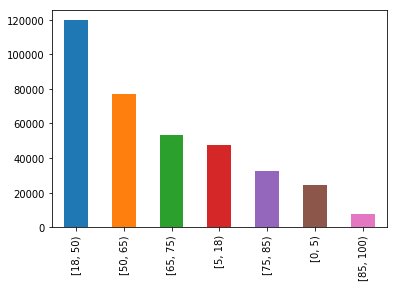

In [28]:
visualize_col(df, 'age')

8527    175590
0       105715
8515     62879
8516     13861
8557      3511
8657      1075
Name: race_concept_id, dtype: int64


visit_concept_id                                0        9201     9202  9203
                           race_concept_id                                  
ARI_symptoms_2_months_bool 0                  3820.0    350.0   3930.0   0.0
                           8515               2496.0    234.0   1987.0   0.0
                           8516                564.0     60.0    318.0   0.0
                           8527               6419.0    740.0   3962.0   2.0
                           8557                192.0     19.0     84.0   NaN
                           8657                 35.0      4.0     21.0   NaN
positive                   0                   643.0     37.0     20.0   0.0
                           8515                 54.0     26.0     13.0   0.0
                           8516                 11.0      3.0      4.0   0.0
                           8527                169.0     50.0     45.0   0.0
                           8557                  3.0      5.0      2.0   NaN
                           8657                  2.0      0.0      0.0   NaN
tested                     0                  5235.0    361.0    299.0   0.0
                           8515               1030.0    218.0    234.0   0.0
                           8516                234.0     81.0     45.0   0.0
                           8527               2978.0    740.0    711.0   2.0
                           8557                 76.0     35.0     12.0   NaN
                           8657                 17.0      5.0      7.0   NaN
total                      0                 73684.0   7481.0  24549.0   1.0
                           8515              44401.0   4173.0  14301.0   4.0
                           8516              10296.0    850.0   2713.0   2.0
                           8527             127590.0  13384.0  34601.0  15.0
                           8557               2591.0    267.0    653.0   NaN
                           8657                772.0     75.0    228.0   NaN

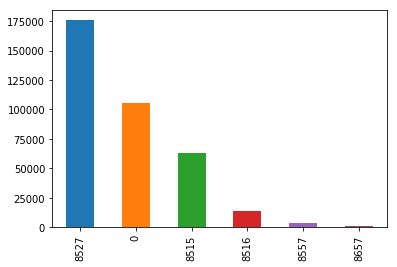

In [29]:
visualize_col(df, 'race_concept_id')

8532    206195
8507    156321
0          115
Name: gender_concept_id, dtype: int64


visit_concept_id                                  0        9201     9202  9203
                           gender_concept_id                                  
ARI_symptoms_2_months_bool 0                       3.0      1.0      2.0   NaN
                           8507                 5796.0    755.0   4932.0   0.0
                           8532                 7727.0    651.0   5368.0   2.0
positive                   0                       0.0      0.0      0.0   NaN
                           8507                  448.0     87.0     43.0   0.0
                           8532                  434.0     34.0     41.0   0.0
tested                     0                      14.0      0.0      0.0   NaN
                           8507                 3815.0    939.0    559.0   2.0
                           8532                 5741.0    501.0    749.0   0.0
total                      0                      95.0      6.0     14.0   NaN
                           8507               109162.0  11793.0  35359.0   7.0
                           8532               150077.0  14431.0  41672.0  15.0

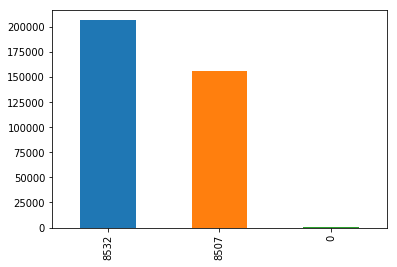

In [30]:
visualize_col(df, 'gender_concept_id')

38003564    258219
0            55465
38003563     48947
Name: ethnicity_concept_id, dtype: int64


visit_concept_id                                   0      9201   9202  9203
                           ethnicity_concept_id                            
ARI_symptoms_2_months_bool 0                       1580     46   2617     0
                           38003563                2320    237   1273     0
                           38003564                9626   1124   6412     2
positive                   0                        548      1      8     0
                           38003563                 109     27     13     0
                           38003564                 225     93     63     0
tested                     0                       4118     16    153     0
                           38003563                1025    226    159     0
                           38003564                4427   1198    996     2
total                      0                      38201   3125  14138     1
                           38003563               35370   3872   9704     1
                           38003564              185763  19233  53203    20

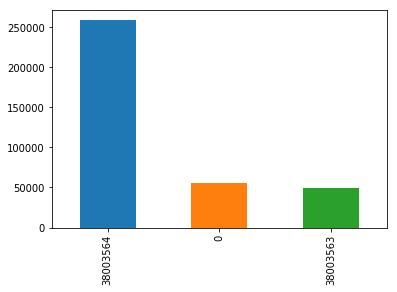

In [31]:
visualize_col(df, 'ethnicity_concept_id')